# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances
to check and fixes them if they had been flipped.

In [1]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts
sys.path.insert(0, os.getcwd() + '/../../')  # for plots

from scripts import cleaning
from scripts.plot import plot_cleaning

In [2]:
args = cleaning.Args()
args.dataset='amazon'
args.n_estimators=250
args.max_depth=5
args.tree_type='cb'
args.tree_kernel='tree_output'
args.kernel_model='klr'
args.check_pct=0.15
args.data_dir='../../data/'
cleaning.main(args)


Seed: 1
no. train instances: 26,215
no. test instances: 6,554
no. features: 9
no. noisy labels: 10,486

Before noise:

train acc: 0.947, auc: 0.894, logloss: 0.154
test  acc: 0.943, auc: 0.821, logloss: 0.178

After noise:

train acc: 0.617, auc: 0.665, logloss: 0.650
test  acc: 0.899, auc: 0.576, logloss: 0.551

Using predicted labels:
incorrectly predicted corrupted labels: 8,934
total number of incorrectly predicted labels: 10,036

ordering by random...


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]

time: 45.065226s
ordering by tree loss...



100%|██████████| 10/10 [00:48<00:00,  4.55s/it]

time: 48.192805s

ordering by TREX...
TREX:
transforming training data...


tuning...
[Fold 1] C=0.01 : 4.083s; corr=0.199
[Fold 1] C=0.1  : 4.062s; corr=0.208
[Fold 1] C=1.0  : 4.410s; corr=0.259
[Fold 1] C=10.0 : 6.080s; corr=0.407
[Fold 1] C=100.0: 8.326s; corr=0.595
[Fold 2] C=0.01 : 6.080s; corr=0.136
[Fold 2] C=0.1  : 4.072s; corr=0.139
[Fold 2] C=1.0  : 4.094s; corr=0.163
[Fold 2] C=10.0 : 3.705s; corr=0.271
[Fold 2] C=100.0: 3.826s; corr=0.440
chosen C: 100.0
total tuning time: 48.765s
training...
total training time: 40.863s


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

time: 169.702422s

ordering by TREX loss...



100%|██████████| 10/10 [00:52<00:00,  5.09s/it]

time: 117.155633s


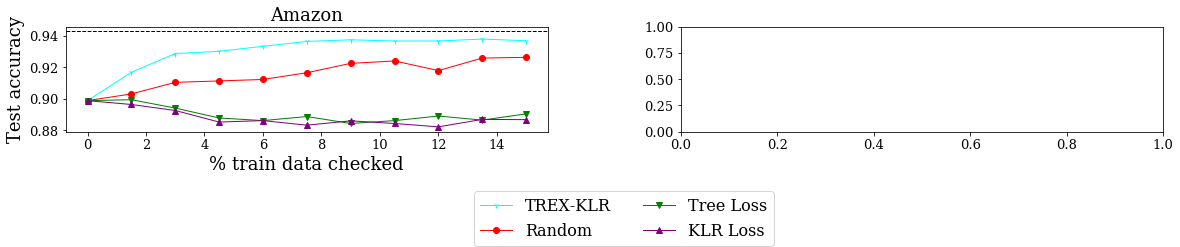

In [2]:
args = plot_cleaning.Args()
args.dataset=['amazon']
plot_cleaning.main(args)